# Tree Models

The goal is to predict SalePrice

In [1]:
KAGGLE=False # set to True if using the Kaggle version of the dataset
WRITE=False

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import catboost as cb

from xgboost import XGBRegressor
import pickle

import shap
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [3]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,KFold, train_test_split
from sklearn.pipeline import Pipeline


In [18]:
plt.rcParams["figure.figsize"] = (20, 10)

In [21]:
from tqdm import tqdm

The data has been pre-processed

In [5]:
alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

In [16]:
alldata_lasso=alldata.drop(['2ndFlrSF'],axis=1)

If working with the Kaggle version of the dataset, can use the function below to do train-test split

In [17]:
def label_encode():
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    for column_name in alldata.columns:
        if alldata[column_name].dtype == object:
            #cat_idxs.append(alldata.columns.get_loc(column_name))
            #alldata[column_name] = alldata[column_name].astype(str)
            alldata[column_name] = le.fit_transform(alldata[column_name])
label_encode()

In [27]:
def train_test_split_custom(data=alldata,y_var='SalePrice',cols=[]):
    y=data[y_var]
    X=data.drop([y_var],axis=1)
    X= X if not cols else X[cols]
    return train_test_split(X, y, test_size=0.2, random_state=42)


# Initial Model Comparisons

100%|██████████| 4/4 [01:12<00:00, 18.21s/it]


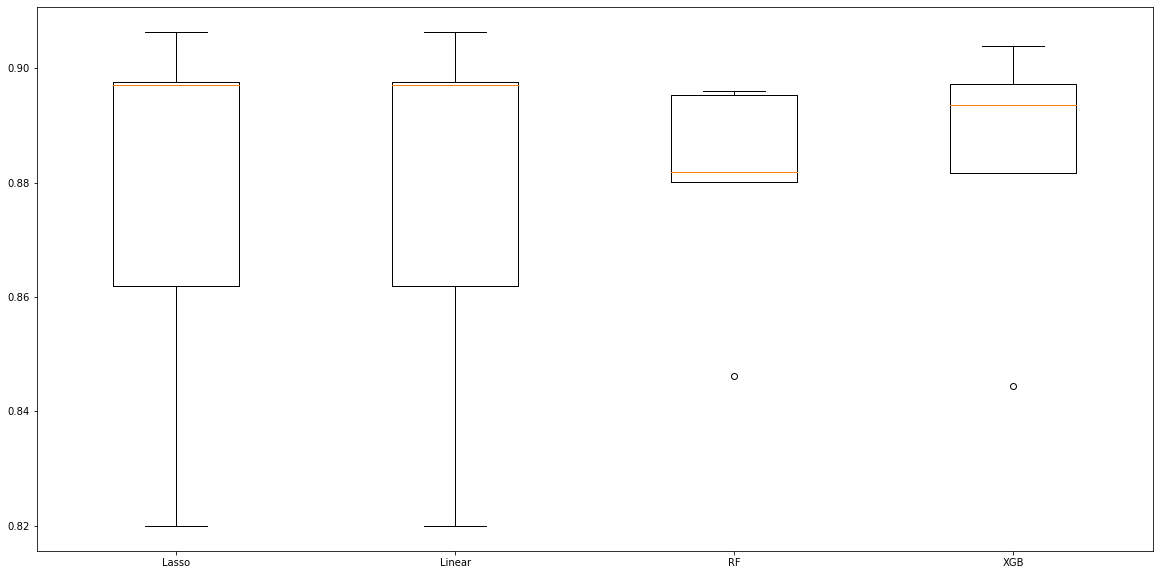

In [23]:
from random import shuffle
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata_lasso)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {"Lasso":Lasso(alpha=.1),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=10)}
results = []
for model in tqdm(models.values()):
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

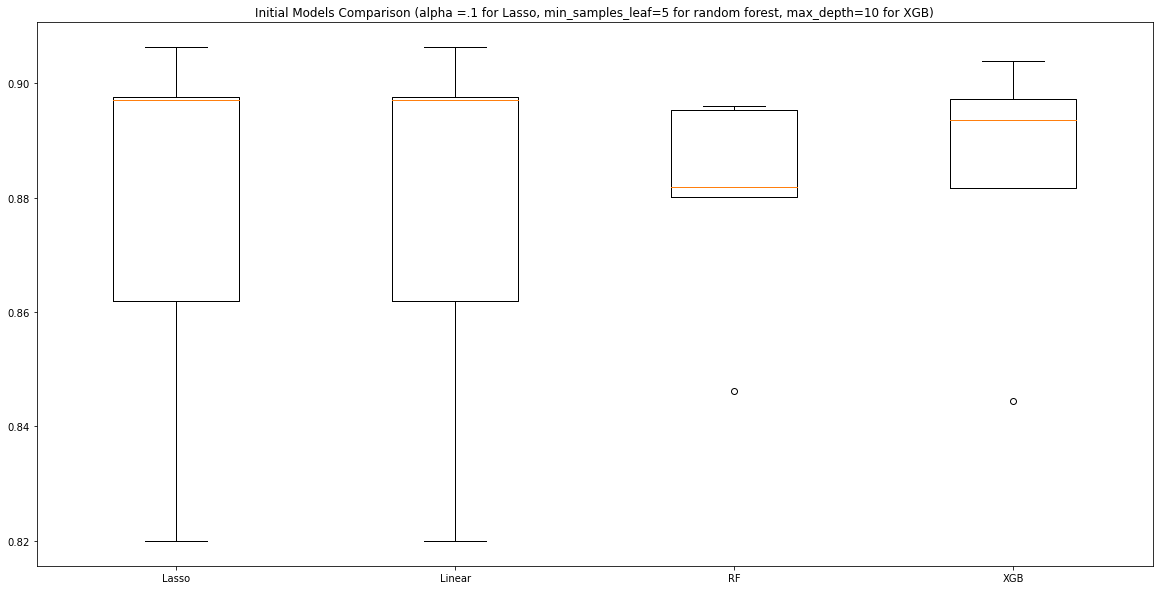

In [25]:
plt.boxplot(results, labels = models.keys())
plt.title('Initial Models Comparison (alpha =.1 for Lasso, min_samples_leaf=5 for random forest, max_depth=10 for XGB)')
plt.show()

In [11]:
# from random import shuffle
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
# "Linear":LinearRegression(),
# "RF":RandomForestRegressor(min_samples_leaf=5),
# "XGB":xgb.XGBRFRegressor(max_depth=10)}
# results = []
# for model in models.values():
#     kf = KFold(n_splits=5,random_state=43,shuffle=True)
#     cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
#     results.append(cv_results)
# plt.boxplot(results, labels = models.keys())
# plt.show()

# Lasso Feature Importances

<AxesSubplot:>

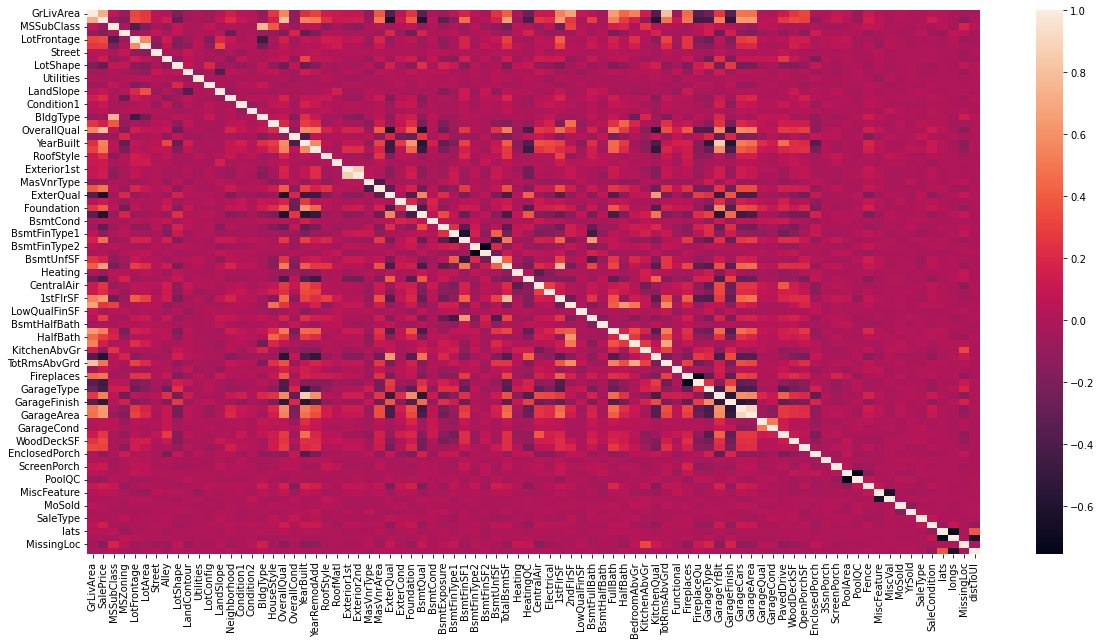

In [34]:
sns.heatmap(alldata.corr())


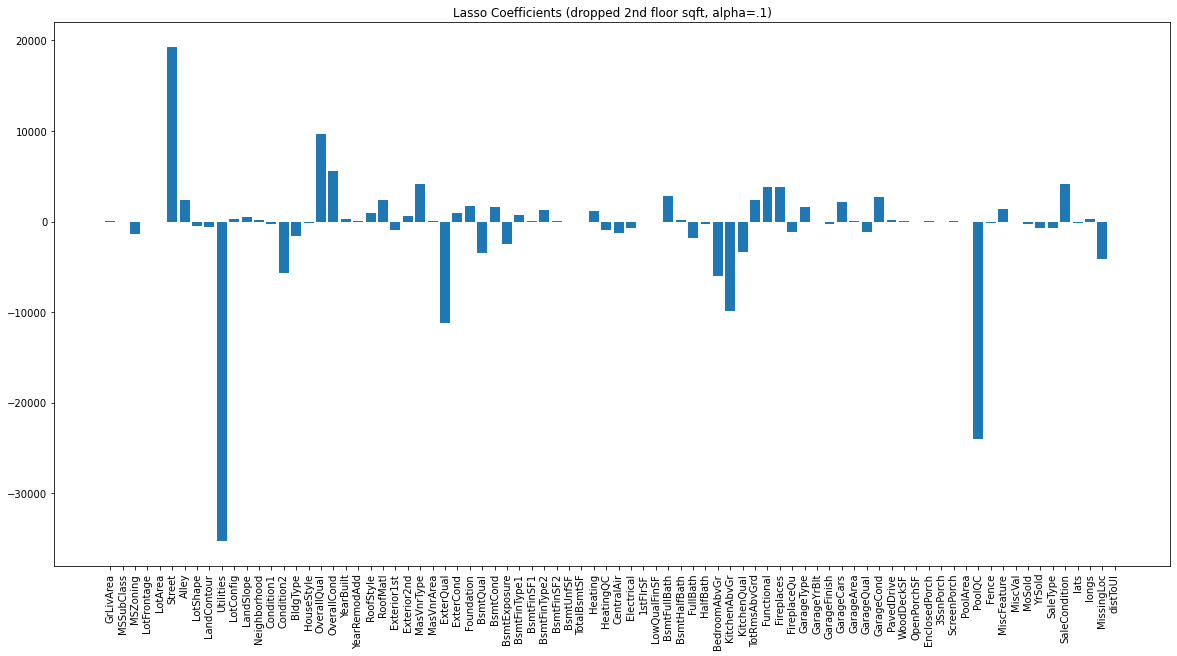

In [26]:
lasso = Lasso(alpha=0.1,max_iter=10000)
y=alldata_lasso['SalePrice'].values
X=alldata_lasso.drop(['SalePrice'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns
lasso_coef = lasso.fit(X,y).coef_
plt.bar(names, lasso_coef)
plt.title('Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

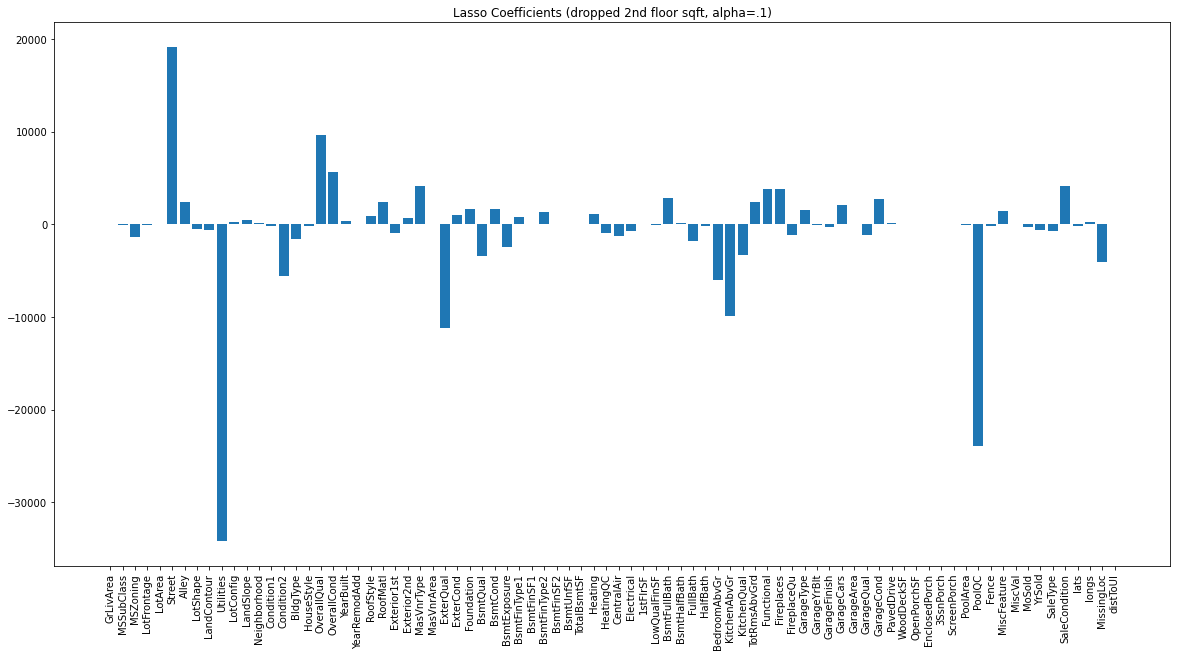

In [54]:
lasso = Lasso(alpha=0.5,max_iter=10000)
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns
lasso_coef = lasso.fit(X,y).coef_
plt.bar(names, lasso_coef)
plt.title('Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata_lasso)  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
lasso_coef=rfe.fit(X_train,y_train)
cols_selected_lasso=list(X_train.columns[rfe.support_])

#cols_selected_lasso

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.


In [35]:
cols_selected_lasso

['Street',
 'LandSlope',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'Heating',
 'CentralAir',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'SaleCondition',
 'MissingLoc']

Text(0.5, 1.0, 'Correlations of Features Selected by Lasso with Sale Price')

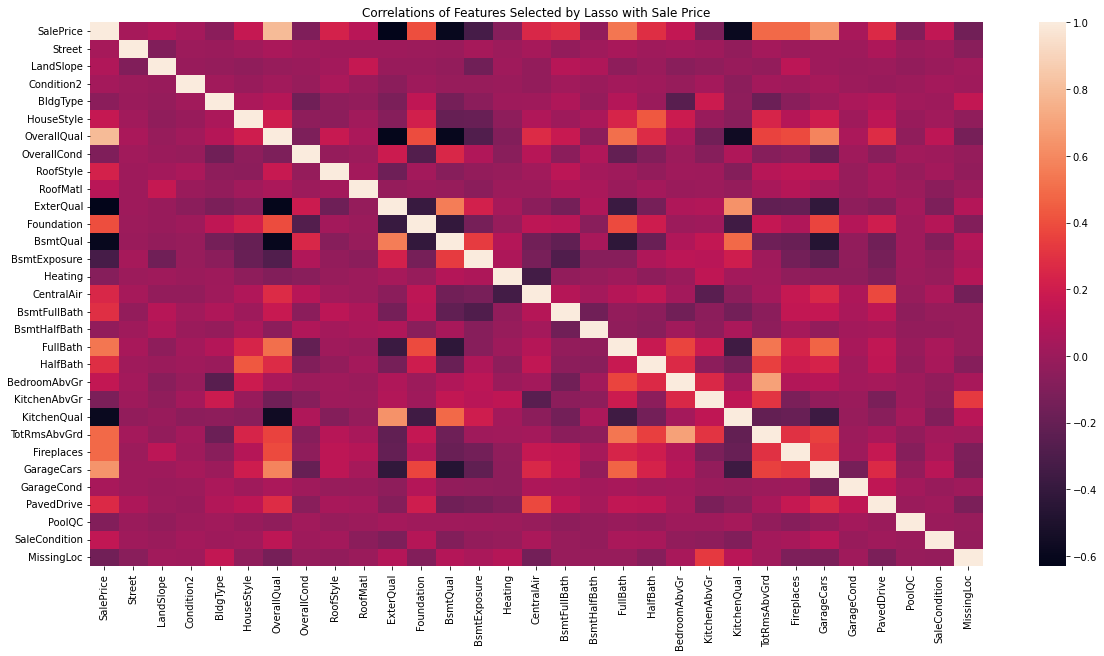

In [42]:
#alldata[cols_selected_lasso].corr()
sns.heatmap(alldata[['SalePrice']+cols_selected_lasso].corr())
plt.title("Correlations of Features Selected by Lasso with Sale Price")


In [53]:
alldata_lasso2 = pd.DataFrame()
alldata_lasso2['LogPrice'] = np.log1p(alldata['SalePrice'])
alldata_lasso2=pd.concat([alldata_lasso2,alldata[cols_selected_lasso]],axis=1)
#alldata_lasso2.drop(['SalePrice'],axis=1)

Text(0.5, 1.0, 'Correlations of Features Selected by Lasso with Log of Sale Price')

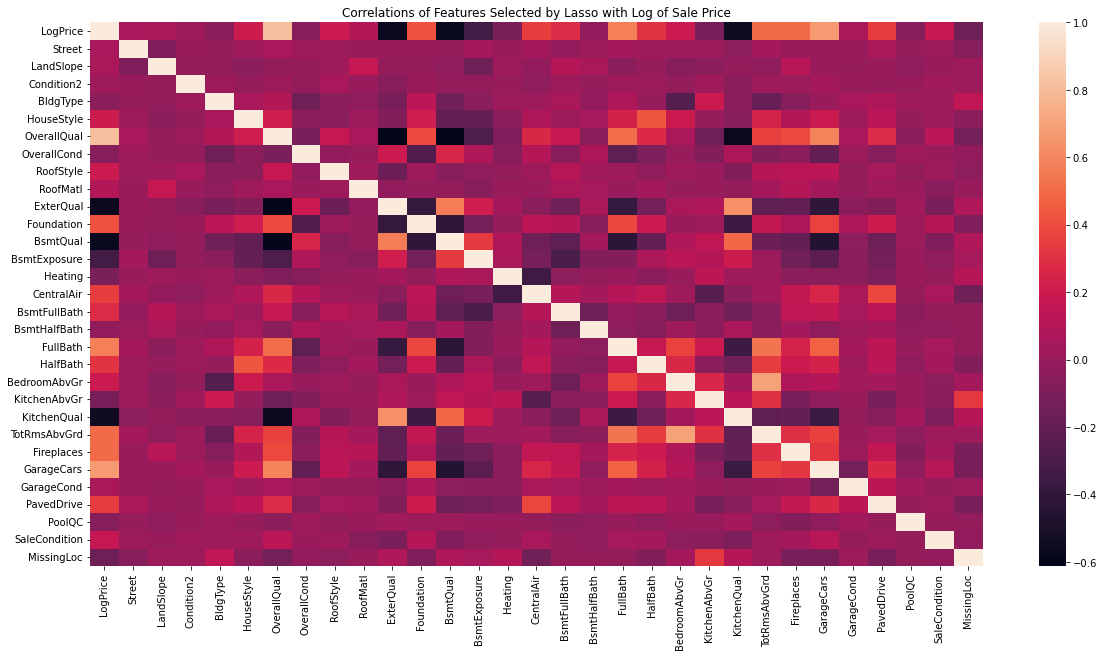

In [54]:
sns.heatmap(alldata_lasso2.corr())
plt.title("Correlations of Features Selected by Lasso with Log of Sale Price")


In [ ]:
cols_selected_lasso=list(X_train.columns[rfe.support_])


# Random Forests

### First fit the 'full' version, which overfits 

In [55]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE : {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 : {r2}')

    return model

In [57]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(min_samples_leaf=5)
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE : 24097.7517764551
R^2 : 0.9018748137558954


RandomForestRegressor(min_samples_leaf=5)

In [13]:
if WRITE:
    pickle.dump(model_rf, open('./models/model_rf_locs_dist_nodpl', 'wb'))


In [58]:
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      0.586021
GrLivArea        0.150577
1stFlrSF         0.047118
TotalBsmtSF      0.032768
GarageArea       0.024792
BsmtFinSF1       0.024346
LotArea          0.011367
YearBuilt        0.010673
FullBath         0.010205
GarageCars       0.008736
MasVnrArea       0.006448
YearRemodAdd     0.005884
longs            0.005596
GarageFinish     0.004720
Fireplaces       0.004391
OpenPorchSF      0.004157
lats             0.003983
BsmtUnfSF        0.003913
WoodDeckSF       0.003757
KitchenQual      0.003574
OverallCond      0.003533
LotFrontage      0.002934
BsmtQual         0.002853
distToUI         0.002746
Neighborhood     0.002507
GarageYrBlt      0.002430
GarageType       0.002395
FireplaceQu      0.002330
MSZoning         0.002299
ExterQual        0.001957
BsmtFinType1     0.001952
TotRmsAbvGrd     0.001922
MoSold           0.001863
MSSubClass       0.001575
BsmtFullBath     0.001393
CentralAir       0.001380
BsmtExposure     0.001016
HeatingQC        0.001006
YrSold      

## Now recursively select features to build a more generalizable model that suffers less from overfitting

In [59]:
rfe = RFE(estimator=RandomForestRegressor(min_samples_leaf=10),
n_features_to_select=30,step=10,verbose=1)
rfe.fit(X_train,y_train)

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.


RFE(estimator=RandomForestRegressor(min_samples_leaf=10),
    n_features_to_select=30, step=10, verbose=1)

In [60]:
rfe.score(X_test,y_test)

0.8928416760148181

- Notice that R^2 is .8925 vs. .9067 for the 'full' model.  Thus the R^2 are similar, yet the model with only 20 features and a minimum of at least 10 observations in each node 
- Does it overfit?

In [61]:
rfe.score(X_train,y_train)

0.9215263392505889

In [62]:
cols_selected_rf=list(X_train.columns[rfe.support_])

In [63]:
y=alldata['SalePrice']
X=alldata.drop(['SalePrice'],axis=1)
X_rf=X[cols_selected_rf]
X_train, X_test, y_train, y_test =  train_test_split(X_rf, y, test_size=0.2, random_state=42)

In [64]:
rf=rfe.estimator.fit(X_train,y_train)
rf.score(X_test,y_test)

0.8906894541103536

- Can train an RF on 20 most important features with little overfitting (under 3% train-test difference)

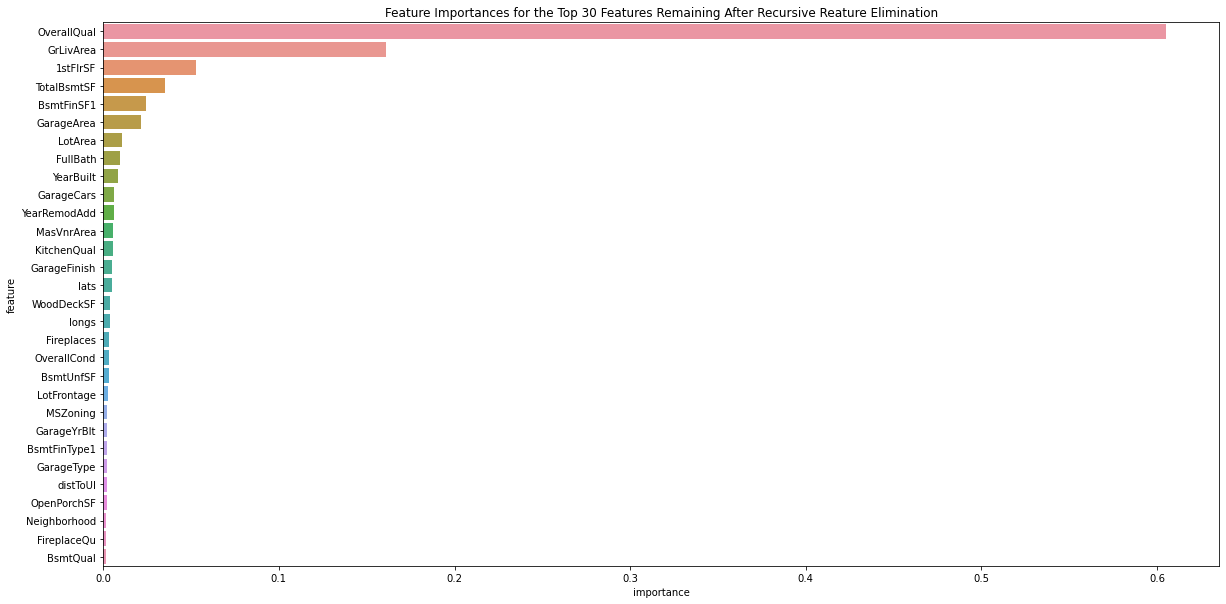

In [66]:
feature_importances = pd.DataFrame({'feature':list(X_test.columns),
                                    'importance':rf.feature_importances_}).sort_values('importance', ascending=False)
sns.barplot(data=feature_importances,x='importance',y='feature')
plt.title("Feature Importances for the Top 30 Features Remaining After Recursive Reature Elimination")
plt.show()


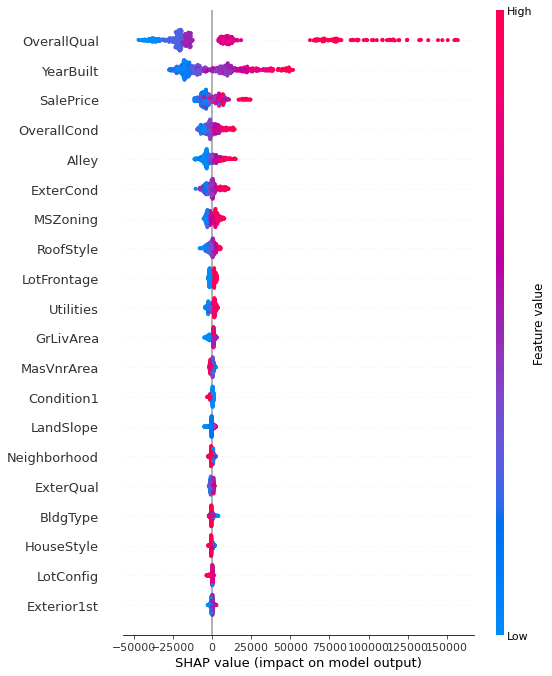

In [221]:
sorted_feature_importance_rf = rf.feature_importances_.argsort()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance_rf])

## Select columns both random forests and Lasso considered important

In [65]:
cols_selected  = list(set(cols_selected_rf)|set(cols_selected_lasso))

In [66]:
len(cols_selected)

52

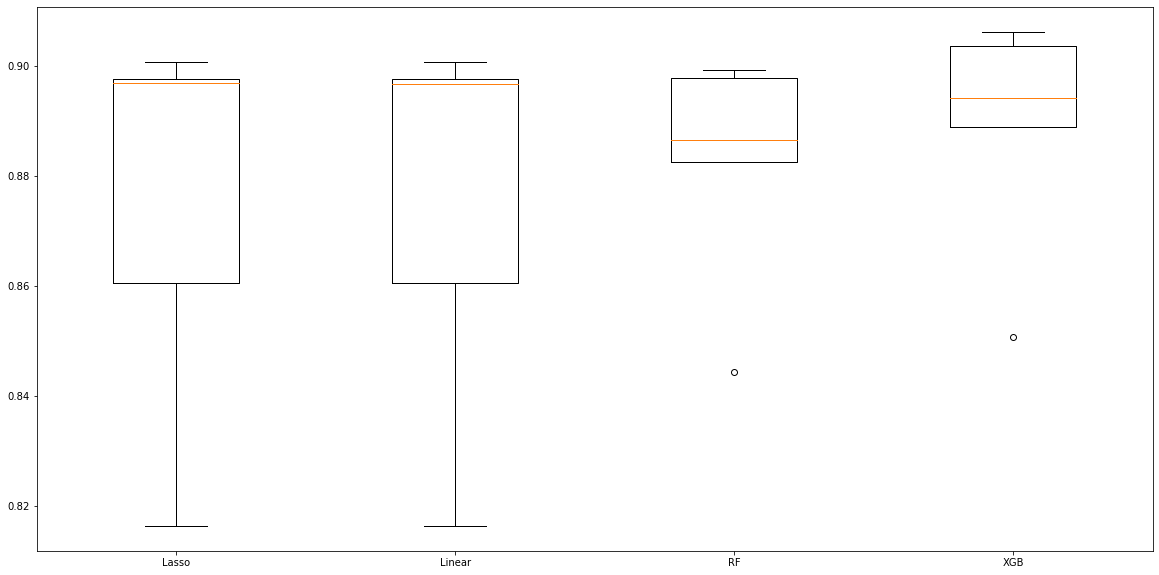

In [71]:
from random import shuffle

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=10)}
results = []
for model in models.values():
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

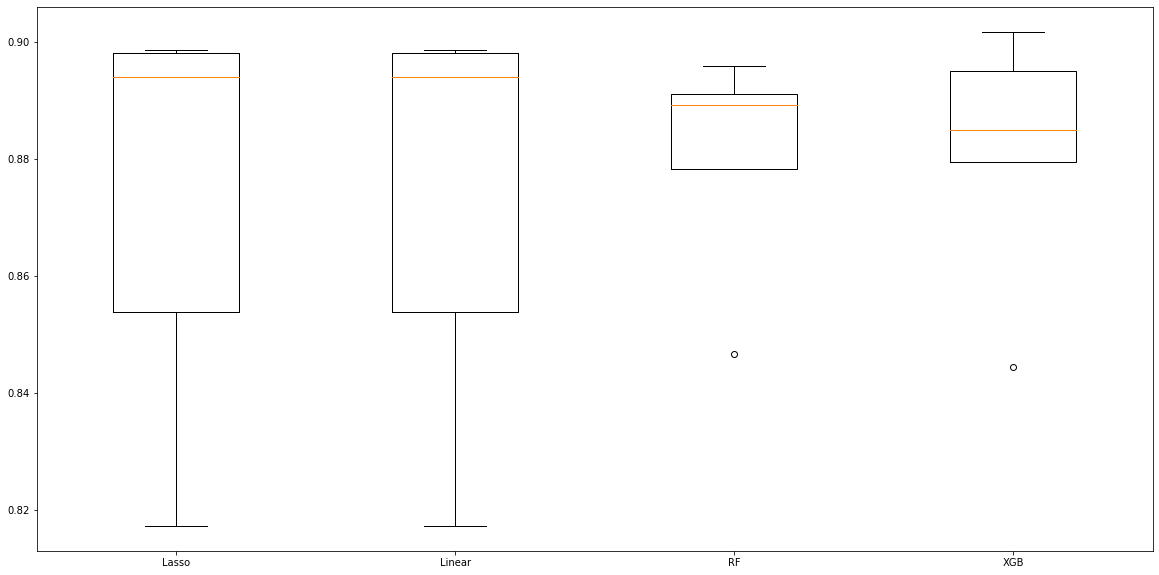

In [78]:
from random import shuffle
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected_rf)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=10)}
results = []
for model in models.values():
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

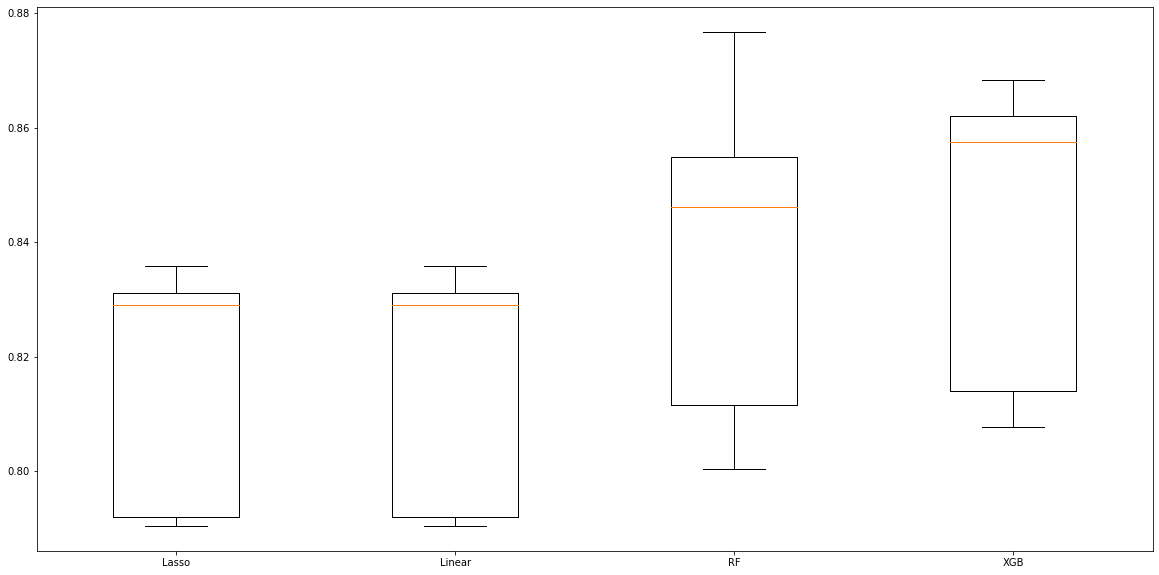

In [79]:
from random import shuffle
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected_lasso)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=10)}
results = []
for model in models.values():
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

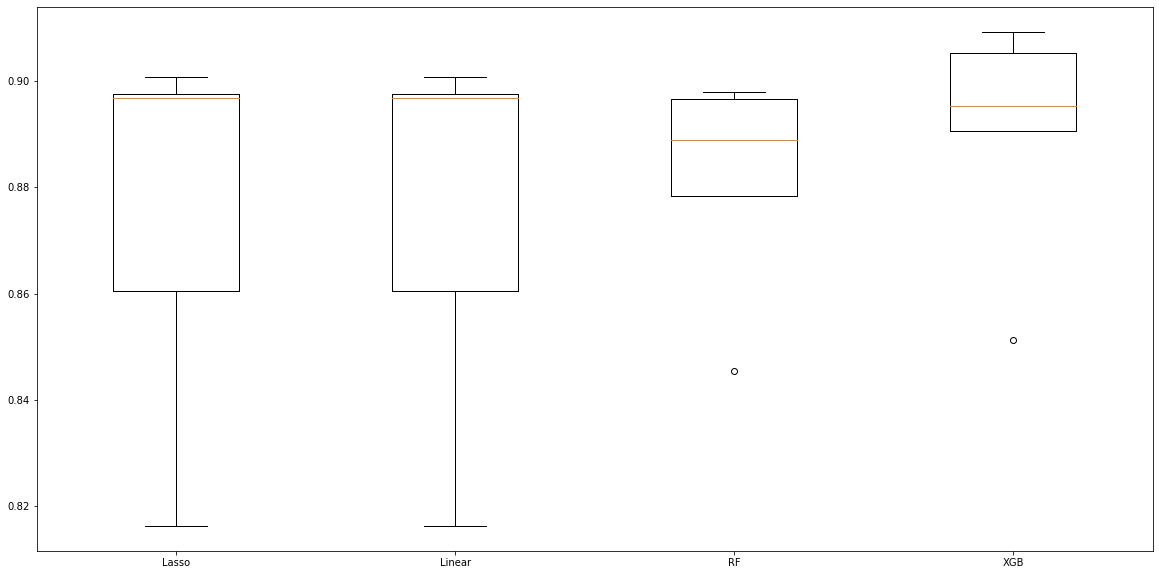

In [72]:
from random import shuffle

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=20)}
results = []
for model in models.values():
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

# Catboost

In [193]:
len(X_train.columns)

52

In [194]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)




It would have been desirable to let CatBoost choose how to encode the catecorical columns
Due to TypeError: Cannot convert 'b'RM'' to float
I chose to LabelEncode beforehand. Otherwise, the code below would work.

In [ ]:
# train_dataset = cb.Pool(X_train, y_train,cat_features=cat_idxs) 
# test_dataset = cb.Pool(X_test, y_test,cat_features=cat_idxs)

In [195]:
model_cb = cb.CatBoostRegressor(loss_function='RMSE',verbose=False)

In [196]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cb.grid_search(grid, train_dataset,verbose=False)


bestTest = 32838.92225
bestIteration = 99


bestTest = 31494.74358
bestIteration = 40


bestTest = 32868.24315
bestIteration = 99


bestTest = 31510.7688
bestIteration = 40


bestTest = 32776.59039
bestIteration = 99


bestTest = 31840.71663
bestIteration = 55


bestTest = 32788.25602
bestIteration = 99


bestTest = 31289.66441
bestIteration = 39


bestTest = 31064.63525
bestIteration = 149


bestTest = 31494.74358
bestIteration = 40


bestTest = 31089.52377
bestIteration = 137


bestTest = 31510.7688
bestIteration = 40


bestTest = 30906.75579
bestIteration = 136


bestTest = 31840.71663
bestIteration = 55


bestTest = 30799.98329
bestIteration = 137


bestTest = 31289.66441
bestIteration = 39


bestTest = 30956.31237
bestIteration = 172


bestTest = 31494.74358
bestIteration = 40


bestTest = 30968.63215
bestIteration = 154


bestTest = 31510.7688
bestIteration = 40


bestTest = 30906.75579
bestIteration = 136


bestTest = 31840.71663
bestIteration = 55


bestTest = 30664.86834
best

{'params': {'depth': 8,
  'l2_leaf_reg': 3,
  'iterations': 200,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [200]:

preds = model_cb.predict(X_test)
print(f'r2 score on train: {r2_score(model_cb.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')
rmse = (np.sqrt(mean_squared_error(y_test, preds)))
print('Testing performance')
print('RMSE: {:.5f}'.format(rmse))


r2 score on train: 0.988684291098846
r2 score on test: 0.9226448253123051
Testing performance
RMSE: 21395.91999


- Catboost overfits

In [201]:
sorted_feature_importance = model_cb.feature_importances_.argsort()

Text(0.5, 0, 'CatBoost Feature Importance')

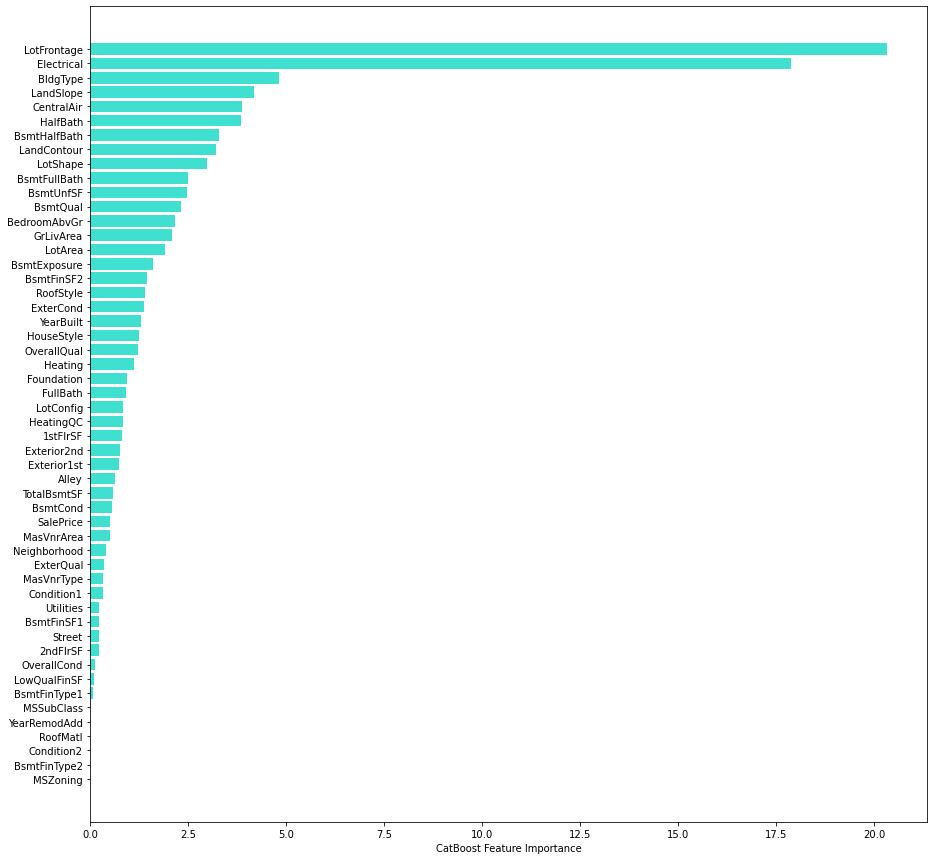

In [202]:
plt.rcParams["figure.figsize"] = (15, 15)

plt.barh(alldata.columns[sorted_feature_importance], 
        model_cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
importances = {}
importances['y'] = pd.Series(model_cb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

GrLivArea        18.032391
OverallQual      17.527542
GarageArea        3.838099
TotalBsmtSF       3.618806
1stFlrSF          3.524429
LotArea           3.206217
BsmtFinSF1        3.165897
KitchenQual       2.417474
lats              2.296543
ExterQual         2.022323
Fireplaces        1.934991
BsmtQual          1.873055
OverallCond       1.759548
YearBuilt         1.723654
BsmtFinType1      1.713439
MSSubClass        1.710691
BsmtExposure      1.518544
GarageType        1.479069
GarageCars        1.426359
Neighborhood      1.355448
distToUI          1.328876
2ndFlrSF          1.281771
GarageYrBlt       1.277074
YearRemodAdd      1.192133
LotShape          1.133216
HalfBath          1.077487
MoSold            1.058839
BsmtFullBath      1.017928
GarageFinish      0.979061
MasVnrArea        0.959242
LotFrontage       0.839934
FireplaceQu       0.769918
WoodDeckSF        0.714193
HeatingQC         0.651914
RoofStyle         0.625016
OpenPorchSF       0.593928
TotRmsAbvGrd      0.582528
C

In [203]:
import shap

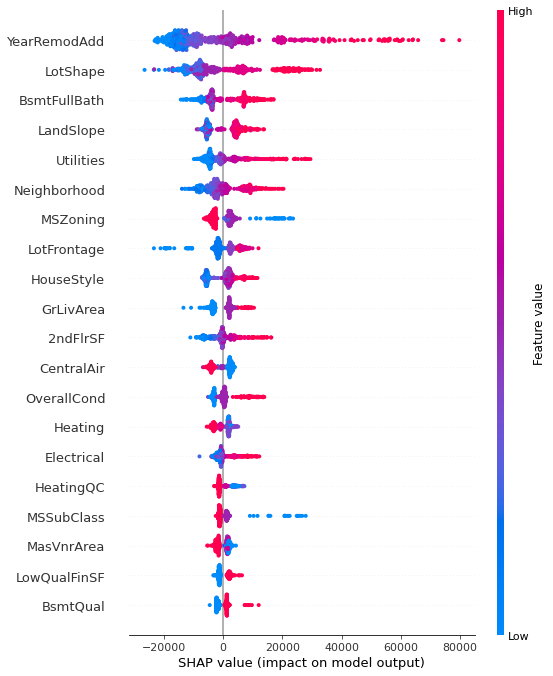

In [204]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

In [ ]:
#catboost has a custom function for saving models: pickle.dump will create problems while blending
model_cb.save_model('./models/model_cb_locs_dist_nodpl') 

# XGBoost

In [10]:
def train_test_split_custom(data=alldata,cols=[]):
    y=data['SalePrice']
    X=data.drop(['SalePrice'],axis=1)
    X= X if not cols else X[cols]
    return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split_custom()  

In [176]:
class TrainXGB:
    def __init__(self,data,model,grid, y_var='SalePrice',cols=[],grid_search=True, n_iters_rs=None):
        self.data = data
        self.cols = cols
        self.y_var = y_var
        self.model=model
        self.grid=grid
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split_custom()  
        self.grid_search = grid_search # True if grid search, False if random search
        self.n_iters_rs = n_iters_rs if n_iters_rs else 10
 
    def __call__(self):    
        cv=KFold(n_splits=5, random_state=42, shuffle=True)

        if self.grid_search:
            search_cv = GridSearchCV(cv=cv,
                        estimator=self.model,
                        n_jobs=2,
                        param_grid=self.grid,
                        return_train_score=True,
                        verbose=1)
        else:
            search_cv = RandomizedSearchCV(cv=cv,
                        estimator=self.model,
                        n_jobs=2,
                        param_distributions=self.grid,
                        return_train_score=True,
                        verbose=1,
                        n_iter=self.n_iters_rs)


        %time obj = search_cv.fit(self.X_train, self.y_train)

        
        preds = search_cv.predict(self.X_test)
        kf = KFold(n_splits=12, random_state=42, shuffle=True)

        print(f'r2 score on train: {r2_score(search_cv.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')
        return search_cv

    def train_test_split_custom(self):
        y=self.data[self.y_var]
        X=self.data.drop([self.y_var],axis=1)
        X= X if not self.cols else X[self.cols]
        return train_test_split(X, y, test_size=0.2, random_state=42)



In [130]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':range(4000,6000,1000)}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                       reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()


Fitting 5 folds for each of 2 candidates, totalling 10 fits


The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.


CPU times: user 1min 5s, sys: 1.04 s, total: 1min 6s
Wall time: 1min 23s
r2 score on train: 0.9973525840026357
r2 score on test: 0.9283442150887822


In [133]:
model_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.6, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=0,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=6e-05, ...)

- First, try to get max_depth right

In [146]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[200,1000],
        'reg_alpha':[.0006,.001,.1],
        'gamma':[1],
        'max_depth':np.arange(2,10)}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\ngamma:{model_xgb.best_estimator_.max_depth}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.reg_alpha}\ngamma:{model_xgb.best_estimator_.gamma}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 16 s, sys: 224 ms, total: 16.2 s
Wall time: 58.5 s
r2 score on train: 0.9921073309955296
r2 score on test: 0.921802074319021
reg_alpha: 0.1
num_estimators: 0.1
gamma:1


- Now, try to regularize

In [149]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[200,1000,2000],
        'reg_alpha':[.001,.1],
        'gamma':[1],
        'max_depth':[6]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\ngamma:{model_xgb.best_estimator_.max_depth}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 33 s, sys: 432 ms, total: 33.4 s
Wall time: 1min 10s
r2 score on train: 0.9980455954488381
r2 score on test: 0.922983113946422

gamma:6
reg_alpha: 0.1
num_estimators: 2000
gamma:1


In [157]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.1,.2,.3],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.5]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 32.6 s, sys: 348 ms, total: 32.9 s
Wall time: 1min
r2 score on train: 0.9955304367198257
r2 score on test: 0.9295693369735181

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 2000
gamma:5


In [158]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.1,.2,.3],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.4]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 29.6 s, sys: 536 ms, total: 30.2 s
Wall time: 1min
r2 score on train: 0.9940059166729079
r2 score on test: 0.933201256867623

max_depth:6
learning_rate:0.01
reg_alpha: 0.1
num_estimators: 2000
gamma:5


In [159]:
pickle.dump(model_xgb,open('./models/xgb_9332_51feats_.4subsample','wb'))

In [160]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.1,.2,.3],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 27.4 s, sys: 384 ms, total: 27.7 s
Wall time: 52.8 s
r2 score on train: 0.9912793207684324
r2 score on test: 0.9310317258915519

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 2000
gamma:5


In [161]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[2000],
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.2,.3,.4,.5,.6,.7]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 25.9 s, sys: 400 ms, total: 26.3 s
Wall time: 1min 27s
r2 score on train: 0.9912913378334266
r2 score on test: 0.9328567171505722

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 2000
gamma:5


In [163]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[1000],
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.2,.3,.4,.5,.6,.7]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 13.8 s, sys: 220 ms, total: 14 s
Wall time: 47.5 s
r2 score on train: 0.9785200940447292
r2 score on test: 0.930077221380623

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 1000
gamma:5


In [164]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':[500],
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.2,.3,.4,.5,.6,.7]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=False, n_iters_rs=10)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 7.08 s, sys: 148 ms, total: 7.23 s
Wall time: 22.8 s
r2 score on train: 0.9584640204278082
r2 score on test: 0.9219215072691608

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 500
gamma:5


In [173]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
#Try grid search in n_estimators 200-400 range
grid_xgb={'n_estimators':np.arange(200,400,20),
        'learning_rate':[.01],
        'reg_alpha':[.2],
        'gamma':[5],
        'max_depth':[6],
        'subsample':[.3],
        'colsample_bytree':[.6]}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(#learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                      # gamma=0.6,
                       #subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                      # reg_alpha=0.00006,
                       random_state=42)
model_xgb=TrainXGB(data=alldata, cols= cols_selected ,model=xgboost,grid = grid_xgb,grid_search=True)()
print(f"\nmax_depth:{model_xgb.best_estimator_.max_depth}\nlearning_rate:{model_xgb.best_estimator_.learning_rate}\nreg_alpha: {model_xgb.best_estimator_.reg_alpha}\nnum_estimators: {model_xgb.best_estimator_.n_estimators}\ngamma:{model_xgb.best_estimator_.gamma}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 5.69 s, sys: 120 ms, total: 5.81 s
Wall time: 27.6 s
r2 score on train: 0.9383825894790574
r2 score on test: 0.9110203568846585

max_depth:6
learning_rate:0.01
reg_alpha: 0.2
num_estimators: 380
gamma:5


In [175]:
pickle.dump(model_xgb,open('./models/xgb_911_51feats_2_7pct_overfit','wb'))

<AxesSubplot:>

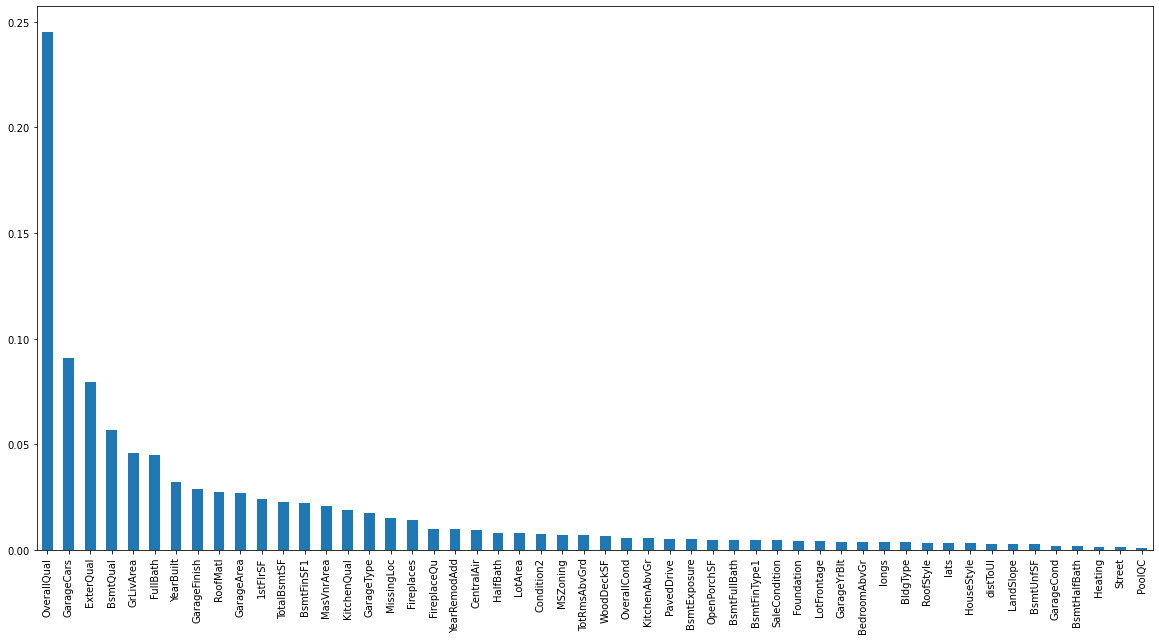

In [181]:
pd.Series(model_xgb.best_estimator_.feature_importances_,X_test.columns).sort_values(ascending=False).plot(kind='bar')

- XGBRegressor overfits since r2 score on train is 0.9997968686776598 and r2 score on test is 0.9213233946437086

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


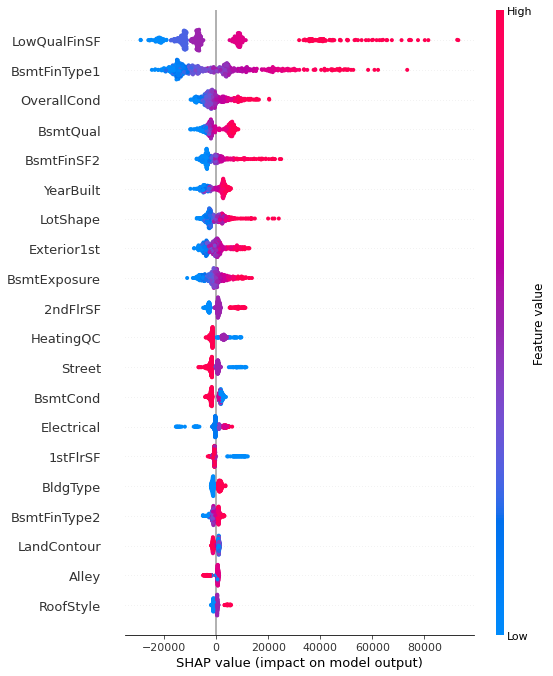

In [184]:
sorted_feature_importance = model_xgb.best_estimator_.feature_importances_.argsort()
explainer = shap.TreeExplainer(model_xgb.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

# Tune Lasso

- Take another look at recursive feature elimination

In [236]:
cols_=(set(alldata.columns)-set(['2ndFlrSF']))-set(['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(cols_))  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
rfe.fit(X_train,y_train)
cols_selected_lasso=list(X_train.columns[rfe.support_])

#cols_selected_lasso

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.


In [237]:
print(cols_selected_lasso)

['BsmtHalfBath', 'KitchenQual', 'HalfBath', 'PavedDrive', 'BsmtFullBath', 'Heating', 'Condition2', 'BsmtExposure', 'BldgType', 'TotRmsAbvGrd', 'SaleCondition', 'GarageCond', 'BedroomAbvGr', 'OverallQual', 'RoofMatl', 'CentralAir', 'MissingLoc', 'ExterQual', 'PoolQC', 'GarageCars', 'Foundation', 'KitchenAbvGr', 'BsmtQual', 'RoofStyle', 'LandSlope', 'Street', 'Fireplaces', 'FullBath', 'HouseStyle', 'OverallCond']


In [ ]:
# cols_=(set(alldata.columns)-set(['2ndFlrSF']))-set(['SalePrice'])

# X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(cols_))  

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)
# rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
# rfe.fit(X_train,y_train)
# cols_selected_lasso=list(X_train.columns[rfe.support_])
# #cols_selected_lasso

In [227]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',Lasso())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(names))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'lasso__alpha':np.arange(.00001, 1, 10)}
#lasso = Lasso()
lasso_cv=GridSearchCV(pipeline, param_grid, cv=kf)
lasso_cv.fit(X_train,y_train)
preds = lasso_cv.predict(X_test)
print(f'r2 score on train: {r2_score(lasso_cv.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
print(f'Lasso best params: {lasso_cv.best_params_}')


r2 score on train: 0.881671969703461
r2 score on test: 0.887597547753441


In [244]:
len(cols_selected)

52

In [242]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',Lasso())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'lasso__alpha':np.arange(.001, 1, 10)}
#lasso = Lasso()
lasso_cv=GridSearchCV(pipeline, param_grid, cv=kf)
lasso_cv.fit(X_train,y_train)
preds = lasso_cv.predict(X_test)
print(f'r2 score on train: {r2_score(lasso_cv.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
print(f'Lasso best params: {lasso_cv.best_params_}')


r2 score on train: 0.8725278190911635
r2 score on test: 0.8843836857005632
Lasso best params: {'lasso__alpha': 0.001}


In [ ]:
AAAA

In [246]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)

pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.872527827667489
r2 score on test: 0.8843835607603977


<AxesSubplot:>

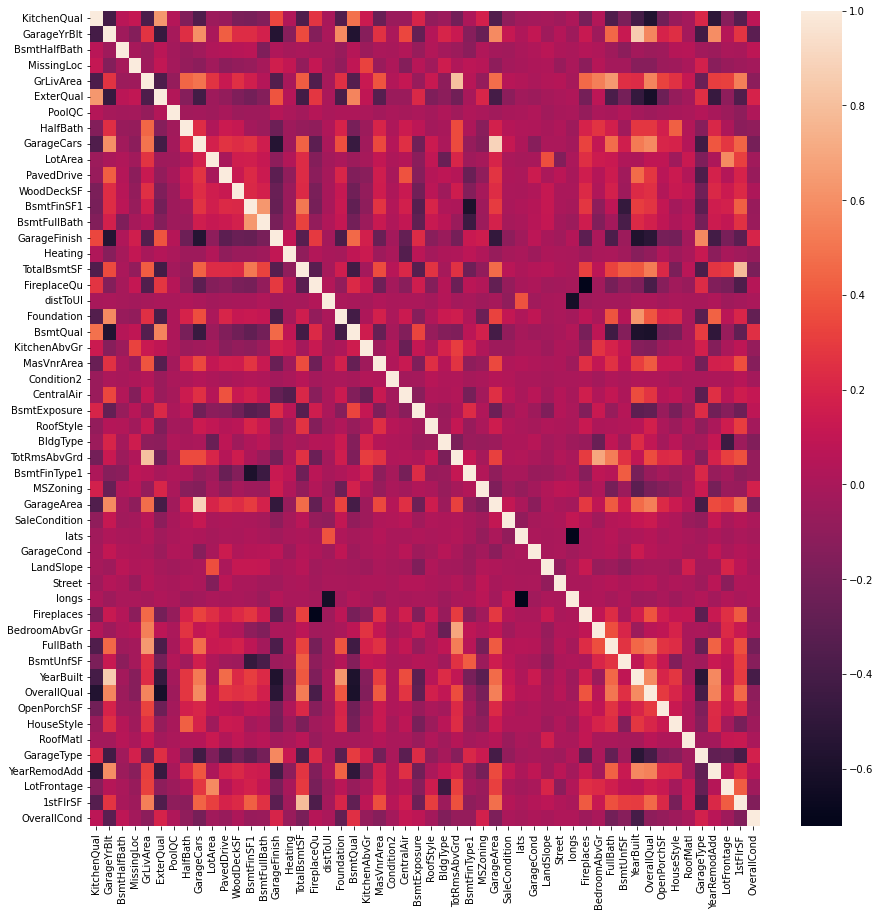

In [247]:
sns.heatmap(alldata[cols_selected].corr())

In [232]:
lasso_cv.best_params_

{'lasso__alpha': 1e-05}

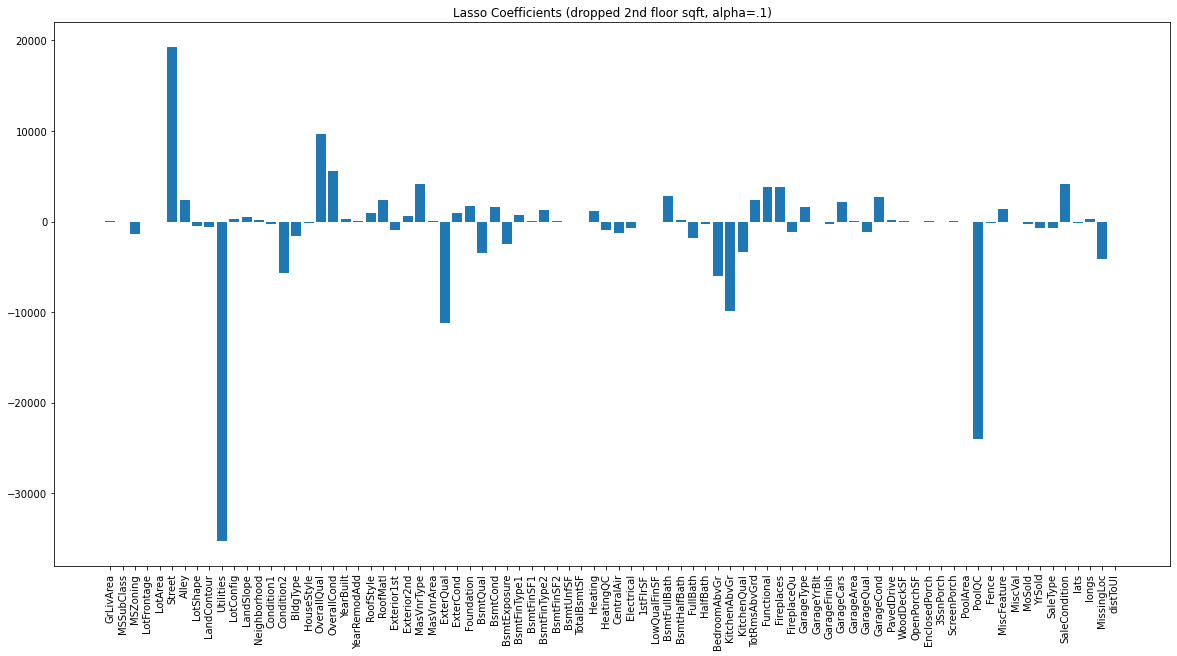

In [ ]:
lasso = Lasso(alpha=0.1,max_iter=10000)
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns
lasso_coef = lasso.fit(X,y).coef_
plt.bar(names, lasso_coef)
plt.title('Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

# Compare a few different models below to get an idea of relative performance

In [187]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
preds=model_lr.predict(X_test)
r2_score(preds,y_test)

0.8679950392640692

In [189]:
from sklearn.ensemble import AdaBoostRegressor
model_ab = AdaBoostRegressor()
model_ab.fit(X_train,y_train)
preds=model_ab.predict(X_test)
r2_score(preds,y_test)

0.762031793599776